In [1]:
import sys
sys.path.append("..")

In [2]:
from src.assay_calibration.fit_utils.two_sample.fit import single_fit
from src.assay_calibration.fit_utils.two_sample import (density_utils,constraints)
import scipy.stats as sps
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import trange

In [3]:
def generate_scoreset(params, weights, sample_sizes):
    samples = []
    sample_assignments = []
    assert weights.shape[1] == len(params)
    assert len(sample_sizes) == weights.shape[0]
    for sampleNum,(sample_weights, sample_size) in enumerate(zip(weights, sample_sizes)):
        comp_sizes = np.round(sample_weights * sample_size).astype(int)
        for compParams, compSize in zip(params, comp_sizes):
            if compSize <= 0:
                continue
            samples.append(sps.skewnorm.rvs(compParams[0], loc=compParams[1], scale=compParams[2], size=compSize))
            sa = np.zeros((sample_size, len(params)), dtype=bool)
            sa[:,sampleNum] = True
            sample_assignments.append(sa)
    return np.concatenate(samples), np.concatenate(sample_assignments)


trueParams = [
    (-2, -3, 2),  # Component 1: a, loc, scale
    (0, 0, 1),   # Component 2: a, loc, scale
    (2, 3, 1)   # Component 3: a, loc, scale
]
trueWeights = np.array([[1, 0, 0],
                        [0, 1, 0],
                        [0, 0, 1]], dtype=float)
assert np.allclose(trueWeights.sum(1), 1)

sample_sizes = np.array([5000,5000, 5000])

scores, sample_assignments = generate_scoreset(trueParams, trueWeights, sample_sizes)

In [4]:
def get_log_density_ratios(score_range, params):
    ratios = np.zeros((len(params) - 1, len(score_range)))
    for i in range(1, len(params)):
        ratios[i-1] = (sps.skewnorm.logpdf(score_range, params[i-1][0], loc=params[i-1][1], scale=params[i-1][2]) -
                       sps.skewnorm.logpdf(score_range, params[i][0], loc=params[i][1], scale=params[i][2]))
    return ratios

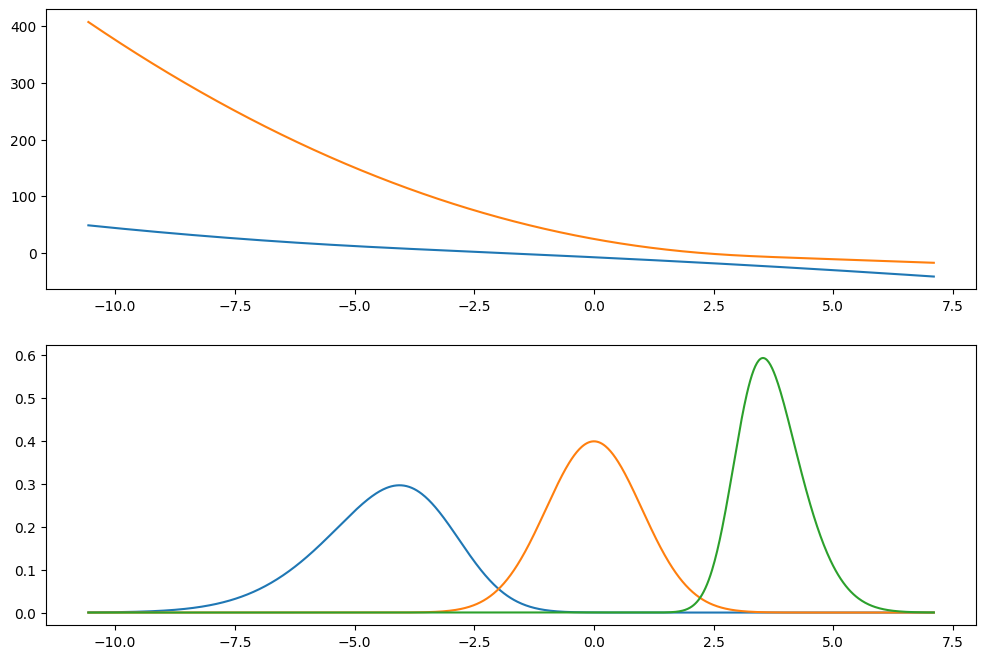

In [5]:
score_range = np.linspace(scores.min(), scores.max(), 1000)
fig,ax = plt.subplots(2,1, figsize=(12,8))
ratios = get_log_density_ratios(score_range, trueParams)
ax[0].plot(score_range, ratios.T)
component_densities = np.array([
    sps.skewnorm.pdf(score_range, a, loc=loc, scale=scale) for a,loc,scale in trueParams
])
for pdf in component_densities:
    ax[1].plot(score_range, pdf)

In [6]:
constraints.multicomponent_density_constraint_violated(trueParams, (scores.min(),scores.max()),)

False

In [7]:
# fit_results = [single_fit(scores,sample_assignments,3, True,
#                           initial_weights=trueWeights,
#                           initial_params=trueParams) for _ in trange(10)]

fit_results = [single_fit(scores,sample_assignments,3,False) for _ in trange(25)]

fit_results = sorted(fit_results, key=lambda res: res['likelihoods'][-1], reverse=True)
best_fit = fit_results[0]

  0%|          | 0/25 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/dz/Documents/research/assay_calibration/test/../src/assay_calibration/fit_utils/two_sample/density_utils.py:31: RuntimeWarning: divide by zero encountered in log
  numerators = log_pdfs + np.log(individual_sample_weights)


In [8]:
score_range = np.linspace(scores.min(), scores.max(), 1000)
trueDensities = np.array([density_utils.joint_densities(score_range[...,None], trueParams, sample_weights).squeeze() for sample_weights in trueWeights])
estimatedDensities = np.array([density_utils.joint_densities(score_range[...,None],
                                                             best_fit['component_params'],
                                                             sample_weights).squeeze() for sample_weights in best_fit['weights']])

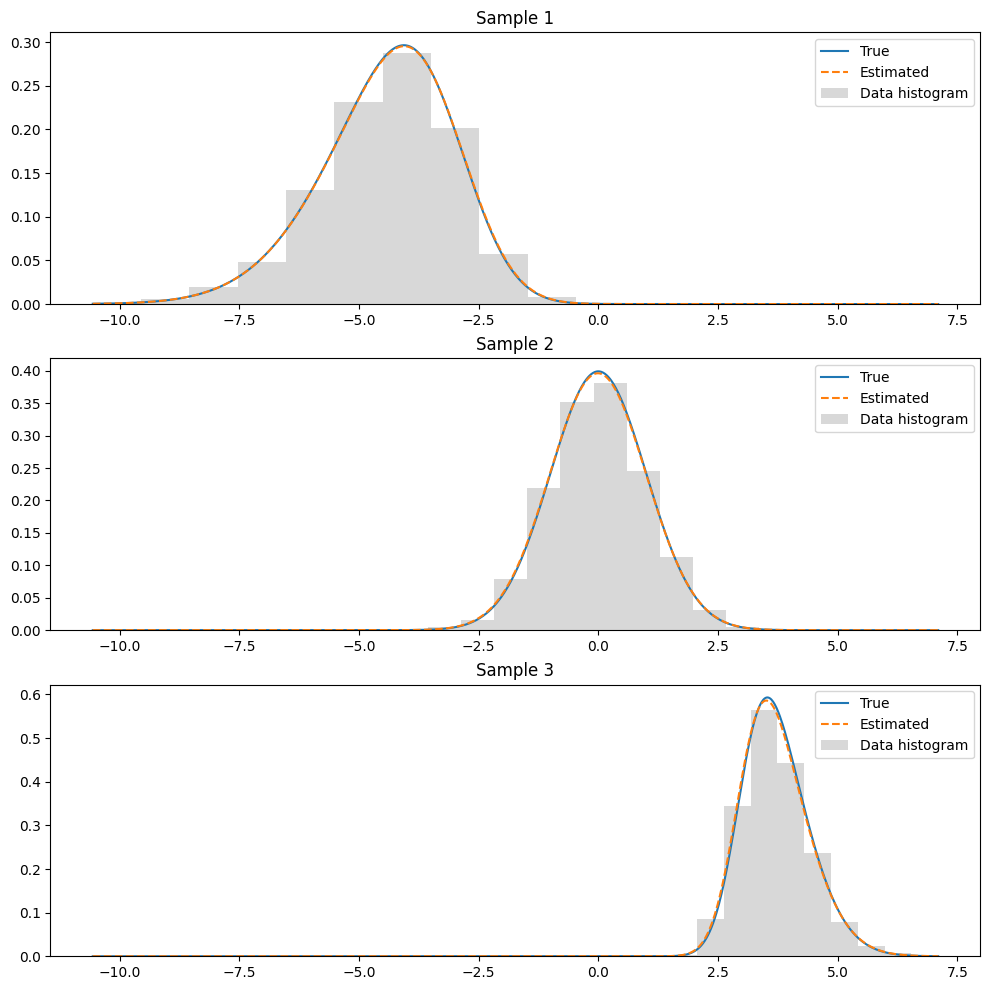

In [9]:
fig,ax = plt.subplots(3,1, figsize=(12,12))
for i in range(3):
    ax[i].plot(score_range, trueDensities[i].sum(0), label='True', color='C0')
    ax[i].plot(score_range, estimatedDensities[i].sum(0), label='Estimated', color='C1', linestyle='--')
    ax[i].hist(scores[sample_assignments[:,i]], density=True, alpha=0.3, color='gray', label='Data histogram')
    ax[i].set_title(f'Sample {i+1}')
    ax[i].legend()

In [10]:
best_fit.keys()

dict_keys(['component_params', 'weights', 'likelihoods', 'history', 'kmeans'])

In [11]:
best_fit['component_params']

[(-1.9902822273568392, -2.9914679027930475, 2.0048547595071127),
 (0.13876378297632538, -0.11873237569251935, 1.013600859117432),
 (2.050437314179738, 2.968422139946502, 1.0192270181740002)]

In [13]:
scores.min(),scores.max()

(np.float64(-10.559818351281645), np.float64(7.0986292871850125))